In [1]:
import os, sys, time, copy
import random
import numpy as np
import matplotlib.pyplot as plt

import multiprocessing
from functools import partial
from tqdm import tqdm

import IPython

import myokit
sys.path.append('../../../')
sys.path.append('../../../Protocols')
sys.path.append('../../../Models')
sys.path.append('../../../Lib')
import protocol_lib
import mod_trace

import simulator_myokit
import simulator_scipy
import vc_protocols

In [2]:
def find_closest_index(array, t):
    """Given an array, return the index with the value closest to t."""
    return (np.abs(np.array(array) - t)).argmin()

def get_currents_with_constant_dt(xs, window=1, step_size=1):
        
    times = xs[0]
    i_ion = xs[1]
              
    i_ion_window = []
    t = 0
    while t <= times[-1] - window:
        start_index = find_closest_index(times, t)
        end_index = find_closest_index(times, t + window)            
        I_window = i_ion[start_index: end_index + 1]                                    
        i_ion_window.append(sum(I_window)/len(I_window))            
        t += step_size
            
    return i_ion_window

### Create Voltage Protocol

In [3]:
# VC_protocol = vc_protocols.hERG_CiPA()
# VC_protocol = vc_protocols.cav12_CiPA()
# VC_protocol = vc_protocols.lateNav15_CiPA()
VC_protocol = vc_protocols.leemV3_1()

vhold = -80 # VC_protocol.steps[0].voltage

cell_types = {
    'Endocardial' : 0,
    'Epicardial' : 1,
    'Mid-myocardial' : 2,
}

cell_type = 'Endocardial'

print(f'The protocol is {VC_protocol.get_voltage_change_endpoints()[-1]} ms')

The protocol is 1600 ms


In [4]:
start_time = time.time()

model, p, s = myokit.load("../../../mmt-model-files/newordherg_qNet_fixedconc-v1.mmt")    
sim = simulator_myokit.Simulator(model, VC_protocol, max_step=0.1, abs_tol=1e-08, rel_tol=1e-8, vhold=vhold)  # 1e-12, 1e-14  # 1e-08, 1e-10
                
sim.model.get('ikr.D').set_rhs( 0 )

gx = 1.0
params = {         
    'cell.mode': cell_types[cell_type],
    'setting.simType': 1,   # 0: AP   |  1: VC  
       
    'ikr.Temp' : 37,
    'ikr.Kt' : 3.5e-05,
    'ikr.Kmax' : 0,
    'ikr.Ku' : 0,
    'ikr.n' : 1,
    'ikr.halfmax' : 1,    
    'ikr.Vhalf' : 1,  
    
    'ina.GNa' : model.get('ina.GNa').value() * gx,   
    'inal.GNaL' : model.get('inal.GNaL').value() * gx,  
    'ito.Gto' : model.get('ito.Gto').value() * gx,
    'ical.PCa' : model.get('ical.PCa').value() * gx,
    'ikr.GKr' : model.get('ikr.GKr').value() * gx, 
    'iks.GKs' : model.get('iks.GKs').value() * gx,
    'ik1.GK1' : model.get('ik1.GK1').value() * gx,
}
sim.set_simulation_params(params)

print("--- %s seconds ---"%(time.time()-start_time))

--- 3.6773276329040527 seconds ---


In [5]:
for key, value in params.items():
    print(f'{key} : {value}')

cell.mode : 0
setting.simType : 1
ikr.Temp : 37
ikr.Kt : 3.5e-05
ikr.Kmax : 0
ikr.Ku : 0
ikr.n : 1
ikr.halfmax : 1
ikr.Vhalf : 1
ina.GNa : 75.0
inal.GNaL : 0.0199575
ito.Gto : 0.02
ical.PCa : 0.0001007
ikr.GKr : 0.04658545454545455
iks.GKs : 0.006358
ik1.GK1 : 0.3239784


In [6]:
def gen_dataset( gen_params, datasetNo=1):    
    '''
    type = 'AP' or 'I" 
    params = {
        'times': 1,                    
        'log_li' : [],
        'nData' : 10000,                         
        'dataset_dir' :   './dataset',        
        'scale' : 2,
    }  
    '''
    random.seed(datasetNo * 84)
    np.random.seed(datasetNo * 86)
    
    # print("-----Dataset%d generation starts.-----"%(datasetNo))

    d = None              
    result_li = []
    param_li = []
    current_nData = 0
    
    simulation_error_count = 0
    with tqdm(total = gen_params['nData']) as pbar:         
        while (current_nData < gen_params['nData']):     

            target = None
            gfc = None

            if gen_params['target_type']=='Gfc':
                target = np.random.uniform(1, 100, 7)                 
                if current_nData==0:
                    target = np.ones(7)            
                elif current_nData==1:
                    target = np.full([7], 100)            
                gfc = target
            elif gen_params['target_type']=='Gr':
                target = np.random.uniform(1e-7, 1, 7)                 
                if current_nData==0:
                    target = np.ones(7)
                elif current_nData==1:
                    target = np.full([7], 1e-7)                                
                gfc = 1.0/target

            Kmax = random.uniform(2.5, 75000000.0)
            Ku = random.uniform(0.0, 1.0)
            n = random.uniform(0.5, 2.0)
            halfmax = random.uniform(9.0, 1000000000.0)
            Vhalf = random.uniform(-200.0, -1.0)
            gfc_li = {     
                'ikr.Kmax' : Kmax,
                'ikr.Ku' : Ku,
                'ikr.n' : n,
                'ikr.halfmax' : halfmax,
                'ikr.Vhalf' : Vhalf,

                'ina.GNafc' : gfc[0],  
                'inal.GNaLfc' : gfc[1],
                'ito.Gtofc' : gfc[2],
                'ical.PCafc' : gfc[3],
                'ikr.GKrfc' : gfc[4],
                'iks.GKsfc' : gfc[5],
                'ik1.GK1fc' : gfc[6], 
            }
            sim.set_simulation_params(gfc_li)             

            # log_li = ['membrane.V']
            # if len(log_li)>0:
            #     log_li = gen_params['log_li']
            try :                
                sim.pre_simulate(5000, sim_type=1)
                d = sim.simulate( gen_params['end_time'], log_times=gen_params['t_eval'], extra_log=gen_params['log_li'])                           

                # temp = [d['engine.time']]
                # for log in gen_params['save_log_li'] :                                              
                #     temp.append(d[log])                 
                # temp = get_currents_with_constant_dt(temp, window=gen_params['window'], step_size=gen_params['step_size'])

                temp = None
                if type(gen_params['t_eval']) != type(None):
                    temp = d['membrane.i_ion']    
                else:
                    temp = [d['engine.time'], d['membrane.i_ion']] 



                if ((gen_params['window']>0) and (gen_params['step_size']>0)):
                    temp = get_currents_with_constant_dt(temp, window=gen_params['window'], step_size=gen_params['step_size'])
                    result_li.append( np.array(temp) )
                else:
                    result_li.append( temp )                                

                param_li.append( [ target[0], target[1], target[2], target[3], target[4], target[5], target[6], Kmax, Ku, n, halfmax, Vhalf ] )
                # param_li.append( target )
                current_nData+=1                   

            except :
                simulation_error_count += 1
                print("There is a simulation error.")
                continue
            
            if datasetNo==gen_params['startNo']:
                pbar.update(1) 
            
    if ((gen_params['window']>0) and (gen_params['step_size']>0)) or (type(gen_params['t_eval']) != type(None)):
        result_li = np.array(result_li)        
    else:
        result_li = np.array(result_li, dtype=object)        
    
    param_li = np.array(param_li)    
    # print(result_li.shape)
    np.save(os.path.join(gen_params['dataset_dir'], f"currents{datasetNo}" ) , result_li)
    np.save(os.path.join(gen_params['dataset_dir'], f'parameter{datasetNo}' ), param_li )

    result_li = []
    param_li = []
    
    print("=====Dataset%d generation End.  &  %d simulation errors occured.====="%(datasetNo, simulation_error_count))       

In [7]:
np.arange(0, VC_protocol.get_voltage_change_endpoints()[-1], 0.1).shape

(16000,)

The number of process : 24
[48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]
The folder already exists.


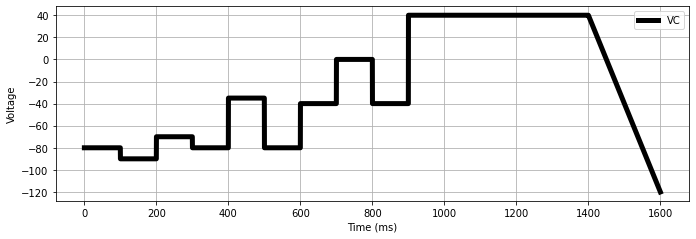

 98%|███████████████████████████████████▍| 9847/10000 [1:16:39<01:09,  2.20it/s]

=====Dataset60 generation End.  &  0 simulation errors occured.=====


  0%|                                               | 0/10000 [1:16:44<?, ?it/s]


=====Dataset58 generation End.  &  0 simulation errors occured.=====


  0%|                                               | 0/10000 [1:16:44<?, ?it/s]


=====Dataset70 generation End.  &  0 simulation errors occured.=====


 99%|███████████████████████████████████▍| 9861/10000 [1:16:46<01:03,  2.20it/s]

=====Dataset49 generation End.  &  0 simulation errors occured.=====


 99%|███████████████████████████████████▌| 9862/10000 [1:16:46<01:07,  2.05it/s]

=====Dataset52 generation End.  &  0 simulation errors occured.=====


 99%|███████████████████████████████████▌| 9866/10000 [1:16:48<01:01,  2.18it/s]

=====Dataset61 generation End.  &  0 simulation errors occured.=====
=====Dataset53 generation End.  &  0 simulation errors occured.=====


 99%|███████████████████████████████████▌| 9876/10000 [1:16:53<00:57,  2.15it/s]

=====Dataset66 generation End.  &  0 simulation errors occured.=====


100%|███████████████████████████████████| 10000/10000 [1:17:42<00:00,  2.14it/s]


=====Dataset57 generation End.  &  0 simulation errors occured.=====
=====Dataset63 generation End.  &  0 simulation errors occured.=====
=====Dataset64 generation End.  &  0 simulation errors occured.=====
=====Dataset55 generation End.  &  0 simulation errors occured.=====
=====Dataset50 generation End.  &  0 simulation errors occured.=====
=====Dataset54 generation End.  &  0 simulation errors occured.=====
=====Dataset51 generation End.  &  0 simulation errors occured.=====
=====Dataset68 generation End.  &  0 simulation errors occured.=====
=====Dataset62 generation End.  &  0 simulation errors occured.=====
=====Dataset67 generation End.  &  0 simulation errors occured.=====
=====Dataset69 generation End.  &  0 simulation errors occured.=====
=====Dataset65 generation End.  &  0 simulation errors occured.=====
=====Dataset56 generation End.  &  0 simulation errors occured.=====
=====Dataset59 generation End.  &  0 simulation errors occured.=====
=====Dataset48 generation End.  & 

In [8]:
if __name__=='__main__':
    start_time = time.time()    
    nCPU = os.cpu_count()      
    nCPU = 24
    print("The number of process :", nCPU )   
   
    multi = True
        
    dt = 0.1 # ms
    gen_params = {
        'end_time': VC_protocol.get_voltage_change_endpoints()[-1],      
        't_eval' : np.arange(0, VC_protocol.get_voltage_change_endpoints()[-1], dt), 
        'log_li' : ['membrane.i_ion'],
        'save_log_li' : ['membrane.i_ion'],         
        'target_type' : 'Gr',
        'dataset_dir' : f'./newordherg_qNet_fixedconc_v1_LeemV31_{cell_type}_dt01_5hERG',        
        'window' : 0,
        'step_size' : 0,
        'nData' : 10000,
        'startNo' : 48,
        'nDataset' : 23,        
    }  
    gen_params['dataset_dir'] = gen_params['dataset_dir'] + f"_{gen_params['target_type']}" #_w{gen_params['window']}_s{gen_params['step_size']}"

    datasetNo_li = list(range(gen_params['startNo'], gen_params['startNo']+gen_params['nDataset']))  # Core 수만큼  [1,2,3,4,5,6,7,8,9,10]    
    print(datasetNo_li)          
        
    try:
        if not os.path.exists(gen_params['dataset_dir']):
            os.makedirs(gen_params['dataset_dir'])
            print('"%s" has been created.'%(gen_params['dataset_dir']))
        else:
            print("The folder already exists.")
    except OSError:
        print('Error: create_folder(). : ' + gen_params['dataset_dir'])
        
    
    '''
    Plot
    '''
    fig, ax = plt.subplots(1,1, figsize=(10,3))    
    # fig.suptitle(sim.name, fontsize=14)
    # ax.set_title('Simulation %d'%(simulationNo))
    # axes[i].set_xlim(model_scipy.times.min(), model_scipy.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    ax.set_xlabel('Time (ms)')       
    ax.set_ylabel(f'Voltage')      
    times = np.linspace(0, VC_protocol.get_voltage_change_endpoints()[-1], 10000)  
    ax.plot( times, VC_protocol.get_voltage_clamp_protocol(times), label='VC', color='k', linewidth=5)     
    ax.legend()
    ax.grid()
    # ax[-1].set_ylim(-5, 5)

    plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.95, wspace=0.5, hspace=0.15)
    plt.show()
    fig.savefig(os.path.join(gen_params['dataset_dir'], "aVC.jpg" ), dpi=100)
        
    if multi :                  
        pool = multiprocessing.Pool(processes=nCPU )
        func = partial(gen_dataset, gen_params)
        pool.map(func, datasetNo_li)
        pool.close()
        pool.join()
    else:
        for No in datasetNo_li :
            gen_dataset(gen_params, No)
        
    # print("Dataset has been generated.")
    
    print("--- %s seconds ---"%(time.time()-start_time))
    
    # 

    # # Set parameter transformation
    # transform_to_model_param = log_transform_to_model_param       # return np.exp(out)
    # transform_from_model_param = log_transform_from_model_param   # return np.log(out)
    
    # logprior = LogPrior(transform_to_model_param, transform_from_model_param)
      
    # p = logprior.sample_without_inv_transform()
    # print(p)
    
    # print(logprior.rmax)
    # print(logprior.rmin)
    # print(5e5)

 

In [10]:
print("Finish")

Finish
